In [11]:
from tensorflow.keras import Model 
from tensorflow.keras.layers import Input
from tensorflow.keras. layers import Conv2D ,ReLU, BatchNormalization, Flatten, Dense, Reshape, Conv2DTranspose, Activation  
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
import numpy as np
import os
import pickle 


class Autoencoder:
  """
  Deep convolutional autoencoder 
  """

  def __init__(self, 
               input_shape, 
               conv_filters,
               conv_kernels,
               conv_strides,
               latent_space_dim):
    self.input_shape= input_shape             #[width,height,channels]
    self.conv_filters = conv_filters          #[2,4,8] etc
    self.conv_kernels = conv_kernels          #[3,5,3] etc
    self.conv_strides = conv_strides          #[1,2,2] etc
    self.latent_space_dim = latent_space_dim  # int(2)

    self.encoder = None 
    self.decoder = None 
    self.model = None 
    self._model_input = None

    self.num_conv_layers = len(conv_filters)
    self._shape_before_bottleneck = None 

    self._build()
  
  def activation_output(self,output_layer=13):
    layer_outputs = [layer.output for layer in self.encoder.layers[0:output_layer]]
    activation_layer = Model(self._model_input, outputs = layer_outputs)
    return activation_layer
                     
    pass
  def summary(self):
    self.encoder.summary()
    self.decoder.summary()
    self.model.summary()
    
  def compile(self,learning_rate=0.0001):
    optimizer = Adam(learning_rate=learning_rate)
    mse_loss = MeanSquaredError()
    self.model.compile(optimizer = optimizer , loss = mse_loss)

  def train(self, x_train,batch_size , num_epochs,):
    self.model.fit(x_train,
                   x_train,
                   batch_size=batch_size,
                   epochs = num_epochs,
                   shuffle = True)
    
  def save(self, save_folder="/content/automodel"):
    self._create_folder_if_it_dosent_exist(save_folder)
    self._save_parameters(save_folder)
    self._save_weights(save_folder)

  def _create_folder_if_it_dosent_exist(self,folder):
    if not os.path.exists(folder):
      os.makedirs(folder)
  
  def _save_parameters(self, save_folder):
    parameters = [self.input_shape, self.conv_filters ,self.conv_kernels, 
    self.conv_strides,self.latent_space_dim]
    save_path = os.path.join(save_folder + "parameters.pkl")
    with open(save_path,"wb") as f:
      pickle.dump(parameters, f)

  def _save_weights(self,save_folder):
    save_path = os.path.join(save_folder + "weights.h5")
    self.model.save_weights(save_path)

  def reconstruct(self,images):
    latent_representations = self.encoder.predict(images)
    reconstructed_images = self.decoder.predict(latent_representations)
    return reconstructed_images,latent_representations
  
  @classmethod
  def load(cls, save_folder = "/content/automodel"):
    parameters_path = os.path.join(save_folder + "parameters.pkl")
    weights_path = os.path.join(save_folder + "weights.h5")
    with open(parameters_path ,"rb") as f:
      parameters = pickle.load(f)
    auto = Autoencoder(*parameters)
    auto.load_weights(weights_path)
    return auto

  def load_weights(self,weights_path):
    self.model.load_weights(weights_path)

  def _build(self):
    self._build_encoder()
    self._build_decoder()
    self._build_autoencoder()
 
 #Build auto encoder 
  def _build_autoencoder(self):
    model_input = self._model_input 
    model_output = self.decoder(self.encoder(model_input))
    self.model = Model(model_input, model_output, name = "autoencoder")

 # Decoder Part 
  def _build_decoder(self):
    decoder_input = self._add_decoder_input()
    dense_layer = self._add_dense_layer(decoder_input)
    reshape_layer = self._add_reshape_layer(dense_layer)
    conv_transpose_layer = self._add_conv_transpose_layers(reshape_layer)
    decoder_output = self._add_decoder_output(conv_transpose_layer)
    self.decoder = Model(decoder_input, decoder_output, name="decoder")

  def _add_decoder_input(self):
    return Input(shape=self.latent_space_dim, name = "decoder_input")

  def _add_dense_layer(self,decoder_input):
    num_neurons = np.prod(self._shape_before_bottleneck)       #bottleneck_dim = [4,4,32] => 4*4*32 == 512 <= num_neurons 
    return Dense(num_neurons , name = "decoder_dense")(decoder_input)
    

  def _add_reshape_layer(self, dense_layer): 
    return Reshape(self._shape_before_bottleneck)(dense_layer)
    
  def _add_conv_transpose_layers(self, x):
    """ loop through all conv layers in reverse order and stop at the first layer"""
    """ last layer is special layer"""
    for layer_index in reversed(range(1,self.num_conv_layers)):
        x = self._add_conv_transpose_layer(layer_index, x)
    return x

  def _add_conv_transpose_layer(self,layer_index, x):
    layer_num = self.num_conv_layers - layer_index
    conv_transpose_layer = Conv2DTranspose(
        filters = self.conv_filters[layer_index],
        kernel_size = self.conv_kernels[layer_index],
        strides = self.conv_strides[layer_index],
        padding = "same",
        name = f"decoder_conv_transpose_layer{layer_num}"

    )
    x = conv_transpose_layer(x)
    x = ReLU(name=f"decoder_relu{layer_num}")(x)
    x = BatchNormalization(name=f"decoder_BN{layer_num}")(x)
    return x 
  
  def _add_decoder_output(self,x):
    conv_transpose_layer = Conv2DTranspose(
        filters = self.input_shape[-1],
        kernel_size = self.conv_kernels[0],
        strides = self.conv_strides[0],
        padding = "same",
        name = f"decoder_conv_transpose_layer{self.num_conv_layers}"

    )
    x = conv_transpose_layer(x)
    return Activation("sigmoid",name="sigmoid")(x)

# Encoder part
  def _build_encoder(self):
    encoder_input = self._add_encoder_input()
    conv_layers = self._add_conv_layers(encoder_input)
    bottleneck = self._add_bottleneck(conv_layers)
    self._model_input = encoder_input
    self.encoder = Model(encoder_input, bottleneck , name ="encoder")     #keras.Model()
  
  def _add_encoder_input(self):
    return Input(shape = self.input_shape, name = "encoder_input")        #keras.layers.Input()
  
  def _add_conv_layers(self, encoder_input):
    """Creates all convolutional blocks in encoder"""
    x = encoder_input 
    for layer_index in range(self.num_conv_layers):
      x = self._add_conv_layer(layer_index, x) 
    return x

  def _add_conv_layer(self, layer_index, x):
    """Adds a convolutional block to a graph of layers consisting of
     conv2d + relu acti + batch_norm"""
    layer_number = layer_index +1
    conv_layer = Conv2D(
        filters = self.conv_filters[layer_index],
        kernel_size = self.conv_kernels[layer_index],
        strides = self.conv_strides[layer_index],
        padding = "same",
        name = f"encoder_conv_layer_{layer_number}"
    )
    x = conv_layer(x)
    x = ReLU(name=f"encoder_relu_{layer_number}")(x)
    x = BatchNormalization(name = f"encoder_batchnorm_{layer_number}")(x)
    return x
  
  def _add_bottleneck(self,x):
    """Flatten data and add bottleneck (Dense layer)"""
    self._shape_before_bottleneck = K.int_shape(x)[1:]  #[batch_size, width, height, channels]: [2,7,7,1]
    x = Flatten()(x)
    x = Dense(self.latent_space_dim, name = "encoder_output")(x)
    return x 
  
  

In [12]:
if __name__ =="__main__":
  auto = Autoencoder(
               input_shape = (28,28,1), 
               conv_filters = (32,64,64,64),
               conv_kernels=(3,3,3,3),
               conv_strides=(1,2,2,1),
               latent_space_dim = 2
               )
  auto.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder_conv_layer_1 (Conv2D (None, 28, 28, 32)        320       
_________________________________________________________________
encoder_relu_1 (ReLU)        (None, 28, 28, 32)        0         
_________________________________________________________________
encoder_batchnorm_1 (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
encoder_conv_layer_2 (Conv2D (None, 14, 14, 64)        18496     
_________________________________________________________________
encoder_relu_2 (ReLU)        (None, 14, 14, 64)        0         
_________________________________________________________________
encoder_batchnorm_2 (BatchNo (None, 14, 14, 64)        256 

In [16]:
auto.encoder.layers

In [17]:
from tensorflow.keras.datasets import mnist

LEARN_RATE,BATCH_SIZE,EPOCHS = 0.0007 ,32 ,20

def load_mnist():
  (x_train,y_train),(x_test,y_test) = mnist.load_data()
  x_train = x_train.astype("float32")/255         #normalisation 
  x_train = x_train.reshape(x_train.shape + (1,))   #add extra dim c
  x_test = x_test.astype("float32")/255         
  x_test = x_test.reshape(x_test.shape + (1,))  
  return x_train, x_test, y_train, y_test

def train(x_train, learning_rate,batch_size,num_epochs):
   auto = Autoencoder(
               input_shape = (28,28,1), 
               conv_filters = (32,64,64,64),
               conv_kernels=(3,3,3,3),
               conv_strides=(1,2,2,1),
               latent_space_dim = 2
               )
   auto.summary()
   auto.compile(learning_rate)
   auto.train(x_train,batch_size,num_epochs)
   return auto 


In [18]:
x_train,_,_,_  = load_mnist()
autoencoder = train(x_train[:10000], LEARN_RATE,BATCH_SIZE,EPOCHS)

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder_conv_layer_1 (Conv2D (None, 28, 28, 32)        320       
_________________________________________________________________
encoder_relu_1 (ReLU)        (None, 28, 28, 32)        0         
_________________________________________________________________
encoder_batchnorm_1 (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
encoder_conv_layer_2 (Conv2D (None, 14, 14, 64)        18496     
_________________________________________________________________
encoder_relu_2 (ReLU)        (None, 14, 14, 64)        0         
_________________________________________________________________
encoder_batchnorm_2 (BatchNo (None, 14, 14, 64)        256 

In [19]:
autoencoder.save("/content/drive/MyDrive/model/auto_encoder_model/")

In [21]:
auto2 = Autoencoder.load("/content/drive/MyDrive/model/auto_encoder_model/")

In [22]:
auto2.summary()


Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder_conv_layer_1 (Conv2D (None, 28, 28, 32)        320       
_________________________________________________________________
encoder_relu_1 (ReLU)        (None, 28, 28, 32)        0         
_________________________________________________________________
encoder_batchnorm_1 (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
encoder_conv_layer_2 (Conv2D (None, 14, 14, 64)        18496     
_________________________________________________________________
encoder_relu_2 (ReLU)        (None, 14, 14, 64)        0         
_________________________________________________________________
encoder_batchnorm_2 (BatchNo (None, 14, 14, 64)        256 

In [31]:
import numpy as np
import matplotlib.pyplot as plt

def select_image(images, labels, num_images=10):
  sample_images_index = np.random.choice(range(len(images)),num_images)
  sample_images = images[sample_images_index]
  sample_labels = labels[sample_images_index]
  return sample_images, sample_labels

def plot_reconstructed_images(images, reconstructed_images):
  fig = plt.figure(figsize = (15,3))
  num_images= len(images)
  for i,(image, reconstructed_image ) in enumerate(zip(images,reconstructed_images)):
    image = image.squeeze()
    ax = fig.add_subplot(2, num_images, i+1)
    ax.axis("off")
    ax.imshow(image, cmap= "gray_r")
    reconstructed_image = reconstructed_image.squeeze()
    ax = fig.add_subplot(2, num_images, i+num_images+1)
    ax.axis("off")
    ax.imshow(reconstructed_image, cmap= "gray_r")


def plot_images_encoded_in_latent_space(latent_representations, sample_labels):
  plt.figure(figsize=(10,10))
  plt.scatter(latent_representations[:,0],
              latent_representations[:,1],
              cmap="gist_rainbow",
              c=sample_labels,
              alpha =0.5,
              s=20)
  plt.colorbar()
  plt.show()

In [33]:
x_train,x_test,y_train,y_test  = load_mnist()


In [34]:
num_samples = 1
sample_images, sample_labels = select_image(x_train, y_train, num_images=num_samples)

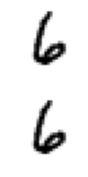

In [36]:
#reconstructed_images,latent_reps = auto2.reconstruct(sample_images)
plot_reconstructed_images(sample_images,reconstructed_images)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

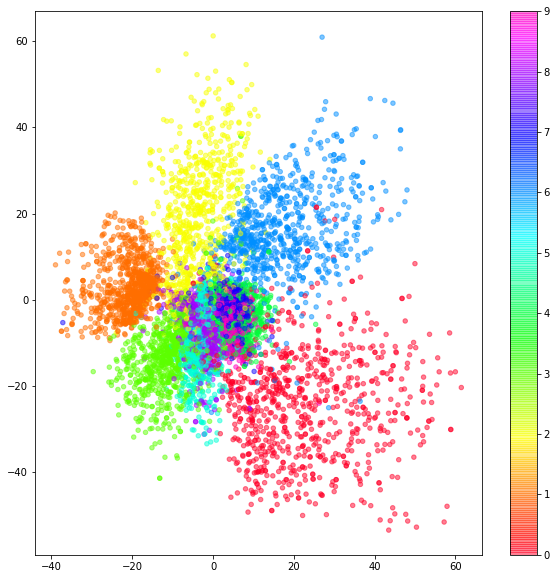

In [ ]:
plot_images_encoded_in_latent_space(latent_reps,sample_labels)

In [37]:
activation = auto2.activation_output()
activation.layers
#img = activation.predict(sample_images)

In [46]:
activation.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder_conv_layer_1 (Conv2D (None, 28, 28, 32)        320       
_________________________________________________________________
encoder_relu_1 (ReLU)        (None, 28, 28, 32)        0         
_________________________________________________________________
encoder_batchnorm_1 (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
encoder_conv_layer_2 (Conv2D (None, 14, 14, 64)        18496     
_________________________________________________________________
encoder_relu_2 (ReLU)        (None, 14, 14, 64)        0         
_________________________________________________________________
encoder_batchnorm_2 (BatchNo (None, 14, 14, 64)        256 

In [50]:
img = activation.predict(sample_images)
act = img[0]

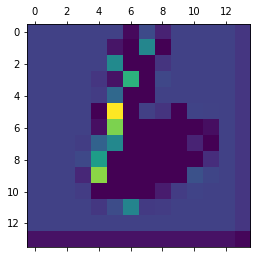

In [59]:
plt.matshow(act[0,:,:,2], cmap="viridis")

In [58]:
act = img[5]
act.shape

(1, 14, 14, 64)

In [45]:
sample_images

array([[[[0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         